# Network data analysis

Most geospatial data is represented in one of two spatial models, **vector-based**, i.e. points, lines and polygons, or **raster-based**, i.e. cells of a continuous grid surface. The vector data model is **feature-oriented**, as it represents space as a series of discrete entities.

Analyzing precisely defined paths, such as roads and rivers or drainage canals, i.e. discrete entities that derive mainly from the built environment, and where attributes play a major role in determining the network.

A network is based much more on the interaction of its component entities than it is based on its component locations. 

But in the real-world networks, such as a road system, must be modelled appropriately to fit into the different spatial models.

https://husdal.com/1999/10/11/network-analysis-raster-versus-vector-a-comparison-study/

Almost everyone has needed a type of network analysis in their life.

For example:

What’s the shortest route to the beach?
Where should I build a hospital to best serve a community?
How can I optimize a vehicle delivery fleet?

## Point-to-point analysis

A point-to-point analysis is the most common routing problem. It consists of a set of points to find the most optimal route based on specific criteria.

Find Nearest – Where is the closest destination? It finds the nearest destination based on a starting point with multiple potential destinations.

Shortest Distance – What’s the fastest route? This analysis accumulates all distances, as you travel out from one point to the other. Then, it finds the route with the least distance.

Fastest route – Which route takes the least amount of time? This network analysis takes into account speed limits, road classification, and other costs to determine the least travel time.

Other types of point-to-point analysis include the most eco-friendly, scenic, and winding routes. Each type of network analysis generates directions from origin to destination.

It can also include the capability to select the mode of travel such as emergency vehicles, trucks, pedestrians, transit, or cycling.

```{image} images/shortest_route.png
:width: 600px
:align: center
```

## Finding coverage

In this type of network analysis, drive-time areas correspond to the distance that can be reached within a specific amount of time.

Service Areas – Which houses are within 5, 10, and 15 minutes from a fire station? This type of network analysis also can understand where businesses cover and if there are any gaps.

Drive-time areas are different from buffers because it takes into account a street network. Buffers can cross water bodies but drive-time areas can only cross water when there’s a bridge.

```{image} images/service_areas.png
:width: 600px
:align: center
```

## Optimize fleet

This tool is ideal when your main goal is to service a set of orders in the traveling salesperson problem. Also, you can best minimize the overall operating cost, by managing sets of vehicles and drivers.

Optimize Fleet – The purpose of this network analysis tool is to find the most efficient route for delivery, repair, transit, or any type of fleet service.

For example, a furniture company might want to use several trucks to deliver furniture to homes. Alternatively, a fleet might want to schedule their weekly visits, including all the logistics.

```{image} images/optimize_fleet.png
:width: 600px
:align: center
```

## Select optimal site

Optimal site selection takes into account the demand to locate the best location given several facilities. For example, it can help decide where to build new hospitals depending on existing hospitals and the available demand.

Location-allocation – this network analysis tool helps business owners pinpoint optimal location for their store. It can also compare with competing stores to target market share.

```{image} images/optimize_sites.png
:width: 600px
:align: center
```

In this lecture we will use the Python library `OSMnx` to download data from **OpenStreetMap (OSM)** and format it into a **graph** model. We will then use the `NetworkX` library to conduct network analysis. 

* Which is the closest cafe?

* How many cafes can we walk to in 15 minutes?

Just remember that while we will be using network analysis on transport infrastructure, these principles apply to many other types of relational data such as international trade, character dialogue in films, or social media.

In [6]:
import numpy as np
import geopandas as gpd

import osmnx as ox
import networkx as nx

from shapely.geometry import Point, LineString, Polygon, MultiPolygon, MultiLineString
from descartes import PolygonPatch

import matplotlib.pyplot as plt
import folium

## Retrieve OSM data

First we will retrieve all features labeled (or tagged) as **buildings** in Eugene from OSM. Don't worry if you're not familiar with OSM or `OSMnx`, we will cover this topic next week in our data access lecture. 

In [8]:
# Specify type of data
tags = {'building': True}

# Download building geometries from OSM
gdf = ox.geometries_from_place('Eugene, Oregon, USA', tags)

/home/johnny/anaconda3/envs/gds/lib/python3.8/site-packages/osmnx/geocoder.py:110: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  gdf = gdf.append(_geocode_query_to_gdf(q, wr, by_osmid))
/home/johnny/anaconda3/envs/gds/lib/python3.8/site-packages/osmnx/geometries.py:805: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  for merged_outer_linestring in list(merged_outer_linestrings):
/home/johnny/anaconda3/envs/gds/lib/python3.8/site-packages/osmnx/geometries.py:805: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for merged_outer_linestring in list(merged_outer_linestrings):


This produces a large `GeoDataFrame` containing over 56,000 buildings. 

In [9]:
print(gdf.shape)

(56025, 246)


For the purposes of this assignment, we are only interested in buildings that are tagged as **cafes**. Cafes are usually tagged as an **amenity** in OSM so we can filter them using a string comparison.

In [10]:
# Filter cafes
cafes = gdf[gdf['amenity'] == 'cafe'].reset_index()
print(cafes.shape)

(35, 248)


We find that there are 35 cafes in Eugene. This could well be an underestimate since there could be cafes that were not tagged as amenities when mapped. But let's keep moving forward and plot them. 

The cafes are acually **polygons** so we will compute their **centroids** to make it simpler to plot. 

In [11]:
# Get cafe centroids
cafes['centroid'] = cafes['geometry'].apply(
  lambda x: x.centroid if type(x) == Polygon else (
  x.centroid if type(x) == MultiPolygon else x))

We can visulize interactively using `folium`. Again don't be too worried if you haven't used this library, we will cover it in a future lecture.

In [12]:
# Define center of map (i.e. Condon Hall) and initial zoom level
lat_lon = [44.0751, -123.0781]
m = folium.Map(location=lat_lon, zoom_start=12)

for i in range(0, cafes.shape[0]):
    my_string = cafes.iloc[i]['name']
    folium.Marker([cafes.iloc[i]['centroid'].y, cafes.iloc[i]['centroid'].x],
                 popup=my_string).add_to(m)

# Display map
m

## Produce a graph (or network)

We will now produce a network using roads, sidewalks, and trails features in OSM. The [`graph`](https://osmnx.readthedocs.io/en/stable/osmnx.html#module-osmnx.graph) module in `OSMnx` automatically process a network topology from raw OpenStreetMap data. 

```{note}
A **network** is also known as a **graph** in mathematics.
```

```{image} images/graph_elements.png
:width: 500px
:align: center
```

We will use the `graph_from_point` function which accepts a **point** (as lat/lon), a **distance** (in meters), and a **network type**. The options for **network type** are available in [documentation](https://osmnx.readthedocs.io/en/stable/osmnx.html#osmnx.graph.graph_from_point) and include `"all_private"`, `"all"`, `"bike"`, `"drive"`, `"drive_service"`, `"walk"`. We choose a distance of **2 miles** and the `walk` option since we are interested in cafes that are walkable. 

In [13]:
# Define coordinates of Condon Hall
lat_lon = (44.0451, -123.0781)

# Define walkable street network 3.2 km around Condon Hall
g = ox.graph_from_point(lat_lon, dist=3200, network_type='walk')

Let's see what the graph looks like...

/home/johnny/anaconda3/envs/gds/lib/python3.8/site-packages/geopandas/plotting.py:74: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if mpl >= LooseVersion("3.4") or (mpl > LooseVersion("3.3.2") and "+" in mpl):
/home/johnny/anaconda3/envs/gds/lib/python3.8/site-packages/setuptools/_distutils/version.py:351: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)


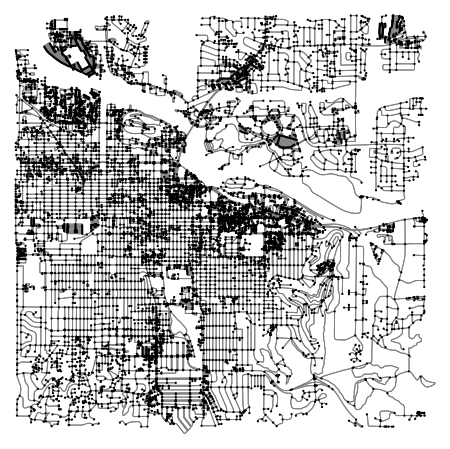

In [14]:
# Plot map
fig, ax = ox.plot_graph(g, bgcolor='white', node_color='black', edge_color='grey', node_size=5)

The first thing to note is that th network structure consists of **nodes** (dots) and **edges** (lines). Nodes represent objects while edges represent the relationship between those objects.

Since our network represents transport infrastructure, nodes represent intersections/dead-ends and edges represent the street segments that link them. If we were studying social relationships between Facebook users, nodes would represent users and edges would represent relationships between them (e.g. friendships or group memberships). 

Also note that the graph is [`MultiDiGraph`](https://networkx.org/documentation/stable/reference/classes/multidigraph.html) `NetworkX` object. `Multi` means that multiple edges are allowed between any pair of nodes. `Di` stands for **directed** which means that all our edges are directional. Bidirectional streets are therefore represented with **two edges** (with identical geometries): one from node 1 to node 2 and another from 2 to 1, to represent both possible directions of flow. 

In [15]:
type(g)

networkx.classes.multidigraph.MultiDiGraph

We can call the [`info`](https://networkx.org/documentation/stable/reference/generated/networkx.classes.function.info.html) function on the graph to see how many nodes and edges it contains.

In [16]:
nx.info(g)

'MultiDiGraph with 11641 nodes and 32994 edges'

## Reproject network

Once we have produced our graph (or network, it is good practice to **reproject** it to UTM coorindates so we can work in SI units (i.e. meters) instead of degrees. The [`graph_project`](https://osmnx.readthedocs.io/en/stable/osmnx.html#osmnx.projection.project_graph) function can be used to reproject the graph. The docs note that if the `to_crs` argument is set to `None`, the graph is projected to the UTM coordinate system for the UTM zone in which the graph's centroid lies. 

In [17]:
# Convert to graph
graph_proj = ox.project_graph(g, to_crs=None)

## Define points of interest

Next we define the centroid locations of Condon Hall and our cafes, making sure that they are in the same projection as our graph (i.e. UTM Zone 10N or EPSG:32610). 

We can find Condon Hall in our original OSM building data using string matching. 

In [18]:
# Get coordinates of Condon Hall
condon_hall = gdf[gdf['name'] == 'Condon Hall'].reset_index()

# Reproject to UTM Zone 10N
condon_hall = condon_hall.to_crs('EPSG:32610')
cafes = cafes.to_crs('EPSG:32610')

Compute centroids...

In [19]:
condon_hall['centroid'] = condon_hall['geometry'].apply(
  lambda x: x.centroid if type(x) == Polygon else (
  x.centroid if type(x) == MultiPolygon else x))

cafes['centroid'] = cafes['geometry'].apply(
  lambda x: x.centroid if type(x) == Polygon else (
  x.centroid if type(x) == MultiPolygon else x))

Format the centroids as a **list**

```{note}
To begin with we will only compute the shortest distance between Condon Hall and the **first** cafe in our `GeoDataFrame`.
```

In [20]:
# Get x and y coordinates of Condon Hall
orig_xy = [condon_hall['centroid'].y.values[0], condon_hall['centroid'].x.values[0]]

# Get x and y coordinates of the first cafe
target_xy = [cafes['centroid'].y.values[0], cafes['centroid'].x.values[0]]

## Find the shortest path between points

The [`distance`](https://osmnx.readthedocs.io/en/stable/osmnx.html#module-osmnx.distance) module in `OSMnx` contains functions for calculating distances, shortest paths, and finding nearest node/edge(s) to point(s). Since the coordinates of our points are unlikely to exactly align with one of the nodes, we first have to find the nearest node to our points using the `nearest_nodes` function. 

In [21]:
# Find the node in the graph that is closest to the origin point
orig_node = ox.distance.nearest_nodes(graph_proj, X=orig_xy[1], Y=orig_xy[0], return_dist=False)

# Find the node in the graph that is closest to the target point
target_node = ox.distance.nearest_nodes(graph_proj, X=target_xy[1], Y=target_xy[0], return_dist=False)

Now we can compute the shortest distance between our two points using the [`shortest_path`](https://networkx.org/documentation/stable/reference/algorithms/shortest_paths.html) functions available from `NetworkX`. The [`shortest_path`](https://networkx.org/documentation/stable/reference/algorithms/generated/networkx.algorithms.shortest_paths.generic.shortest_path.html#networkx.algorithms.shortest_paths.generic.shortest_path) function returns a list of nodes along the shortest path, and the [`shortest_path_length`](https://networkx.org/documentation/stable/reference/algorithms/generated/networkx.algorithms.shortest_paths.generic.shortest_path_length.html#networkx.algorithms.shortest_paths.generic.shortest_path_length) function returns the length of this path.

```{note}
The `weight` argument defines the edge attribute to minimize when solving shortest path. In our case, we would like the **shortest distance** so we choose `length`. 
```

In [22]:
# Calculate the shortest path
route = nx.shortest_path(G=graph_proj, source=orig_node, target=target_node, weight='length')
length = nx.shortest_path_length(G=graph_proj, source=orig_node, target=target_node, weight='length')

In [23]:
print("Shortest path distance = {t:.1f} km.".format(t=length/1000))

Shortest path distance = 4.0 km.


The `route` variable contains a list of the nodes constituting the shortest path between the two points. It can plotted using the `plot_route_folium` function.

In [24]:
# Plot the shortest path using folium
m = ox.plot_route_folium(g, route, weight=5)
m

## Find the distance to many cafes

To compute the shortest distance from Condon Hall to **all** the cafes in Eugene we can make a list of all target locations, find the nearest node for each target location, and loop over them like so...

In [25]:
target_xy = [cafes['centroid'].y.values, cafes['centroid'].x.values]

target_nodes = ox.distance.nearest_nodes(graph_proj, X=target_xy[1], Y=target_xy[0], return_dist=False)

routes = []
lengths = []
for i in range(len(target_nodes)):
    routes.append(nx.shortest_path(G=graph_proj, source=orig_node, target=target_nodes[i], weight='length'))
    lengths.append(nx.shortest_path_length(G=graph_proj, source=orig_node, target=target_nodes[i], weight='length'))

In [26]:
# Plot the shortest path using folium
m = ox.plot_route_folium(g, routes[3], weight=5)
m

Make a list of the nearest ten cafes from Condon Hall.

In [27]:
cafes['distance_km'] = np.array(lengths) / 1000
cafes[['name', 'distance_km']].nsmallest(columns='distance_km', n=10)

,name,distance_km
5,Espresso Roma,0.161636
7,Greenleaf Juicing Company,0.247389
10,Dutch Bros. Coffee,1.063585
4,Starbucks,1.219387
16,The Rabbit Hole,1.457497
6,Dutch Bros. Coffee,1.509738
9,Voodoo Doughnut,1.574858
2,Brail's Espresso,1.597215
33,Cafe Yumm,1.598502
34,Magpie Coffeeshop,1.670554


Finally, we can convert distance to time using an assumed walking speed of 4.5 kph (or 2.8 mph).

In [28]:
travel_speed_minutes = 4.5 / 60

In [29]:
cafes['time_minutes'] = cafes['distance_km'] / travel_speed_minutes
cafes[['name', 'distance_km', 'time_minutes']].nsmallest(columns='distance_km', n=10)

,name,distance_km,time_minutes
5,Espresso Roma,0.161636,2.155147
7,Greenleaf Juicing Company,0.247389,3.298520
10,Dutch Bros. Coffee,1.063585,14.181133
4,Starbucks,1.219387,16.258493
16,The Rabbit Hole,1.457497,19.433293
6,Dutch Bros. Coffee,1.509738,20.129840
9,Voodoo Doughnut,1.574858,20.998107
2,Brail's Espresso,1.597215,21.296200
33,Cafe Yumm,1.598502,21.313360
34,Magpie Coffeeshop,1.670554,22.274053


## Isochrones

Another way to approach this problem would be to find all the **buildings** that we would be prepared to walk to in a **given time period**, and then find all buildings labeled as cafes. This may be a more logical approach since we don't have to rely on finding all the cafes at the start of the analysis - and we know some are likely to be missing. We can also visualize our results using an [**isochrone map**](https://en.wikipedia.org/wiki/Isochrone_map), a popular type of map where each color represents an area accessible from a point within a certain time threshold. 

## Edge and node attributes

To conduct this analysis, it is useful to spend a little more time thinking about the attributes of **nodes** and **edges** of the `MultiDiGraph` object that is produced by `OSMnx`.

In [30]:
type(graph_proj)

networkx.classes.multidigraph.MultiDiGraph

We can explore the **edge** and **node** attributes easier if we convert the `MultiDiGraph` to a `GeoDataFrame`. We'll have a look at the nodes first since they are a bit more intuitive. In our infrastructure network, nodes represent intersections/dead-ends, 

In [31]:
nodes = ox.graph_to_gdfs(graph_proj, nodes=True, edges=False)
edges = ox.graph_to_gdfs(graph_proj, nodes=False, edges=True)

### Nodes

In [32]:
nodes.head()

,y,x,street_count,lon,lat,highway,geometry
osmid,,,,,,,
39649644,4.878377e+06,492202.469421,3,-123.097353,44.058520,NaN,POINT (492202.469 4878377.157)
9127143342,4.878355e+06,492209.299667,3,-123.097268,44.058322,NaN,POINT (492209.300 4878355.202)
7391423647,4.878469e+06,492202.385688,3,-123.097356,44.059347,NaN,POINT (492202.386 4878468.978)
39649646,4.878275e+06,492203.254169,3,-123.097342,44.057603,NaN,POINT (492203.254 4878275.306)
7391423890,4.878276e+06,492156.438857,3,-123.097926,44.057611,NaN,POINT (492156.439 4878276.283)


* The **nodes** `GeoDataFrame` is indexed by an `osmid` which provides a unique identifier for each node. 

* We then have `y` and `x` columns that represent location in **UTM Zone 10 N** coordinates (since we reprojected earlier). The `geometry` column also looks to be in UTM Zone 10 N so we know we are working in meters, not degrees. 

* The `street_count` column provides the number of street segments connected to each node. The `highway` column provides the type of intersection. 

In [33]:
nodes['highway'].unique()

array([nan, 'traffic_signals', 'crossing', 'turning_circle',
       'motorway_junction', 'stop', 'turning_loop', 'services'],
      dtype=object)

### Edges

Edges represent street segments and there are a few more columns to interpret. 

In [34]:
edges.head()

osmid lanes                 name  \
u          v          key                                          
39649644   9127143342 0     713160022     2  Skinners Butte Loop   
           7391423647 0     713160022     2  Skinners Butte Loop   
           39649646   0    1054883373   NaN       Lincoln Street   
9127143342 39649644   0     713160022     2  Skinners Butte Loop   
           9127143339 0     987440284   NaN                  NaN   

                                highway  oneway   length  \
u          v          key                                  
39649644   9127143342 0    unclassified   False   23.012   
           7391423647 0    unclassified   False   92.181   
           39649646   0     residential   False  102.018   
9127143342 39649644   0    unclassified   False   23.012   
           9127143339 0         service   False   13.919   

                                                                    geometry  \
u          v          key                                                      
39649644   9127143342 0    LINESTRING (492202.469 4878377.157, 492209.300...   
           7391423647 0    LINESTRING (492202.469 4878377.157, 492199.636...   
           39649646   0    LINESTRING (492202.469 4878377.157, 492201.283...   
9127143342 39649644   0    LINESTRING (492209.300 4878355.202, 492202.469...   
           9127143339 0    LINESTRING (492209.300 4878355.202, 492223.103...   

                          service access  ref maxspeed bridge width junction  \
u          v          key                                                      
39649644   9127143342 0       NaN    NaN  NaN      NaN    NaN   NaN      NaN   
           7391423647 0       NaN    NaN  NaN      NaN    NaN   NaN      NaN   
           39649646   0       NaN    NaN  NaN      NaN    NaN   NaN      NaN   
9127143342 39649644   0       NaN    NaN  NaN      NaN    NaN   NaN      NaN   
           9127143339 0       NaN    NaN  NaN      NaN    NaN   NaN      NaN   

                          tunnel  
u          v          key         
39649644   9127143342 0      NaN  
           7391423647 0      NaN  
           39649646   0      NaN  
9127143342 39649644   0      NaN  
           9127143339 0      NaN

* The **edges** `GeoDataFrame` is indexed by `u` and `v` which represent the start and end nodes for the edge. The `key` attribute differentiates between parallel edges. In other words, two edges that are between the same two nodes but differ in other attributes.

* Each edge has an `osmid` but, in this framework, it's more convenient to work with the nodes at either end of the edge. 

* The columns `name`, `oneway`, `length` (in meters), `geometry`, `bridge`, `width`, `junction`, and `tunnel` are self-explanatory.

* The `highway` column is provides the type of street segment (e.g. residential, footway, path). 

```{note}
We have to use a **for loop** to get the unique values because there some roads are labeled more than once. 
```

In [35]:
unique_values = []
for item in list(edges['highway']):
    if item not in unique_values:
        unique_values.append(item)
print(unique_values)

['unclassified', 'residential', 'service', 'footway', 'tertiary', 'primary', 'primary_link', 'tertiary_link', 'secondary', ['residential', 'service'], ['footway', 'path'], 'path', 'secondary_link', 'track', ['residential', 'tertiary'], ['residential', 'footway'], ['service', 'footway'], 'busway', 'living_street', ['secondary', 'tertiary'], ['residential', 'secondary'], ['residential', 'path'], ['residential', 'steps', 'path'], ['steps', 'footway'], 'pedestrian', ['track', 'residential'], 'steps', ['service', 'path'], ['pedestrian', 'residential'], ['residential', 'pedestrian'], ['pedestrian', 'footway'], ['primary', 'residential', 'primary_link'], ['unclassified', 'residential'], ['steps', 'path'], ['residential', 'steps', 'footway'], ['service', 'footway', 'path'], ['track', 'service']]


* The `service` column is provides the type of service road (e.g. driveway, alley).

In [36]:
unique_values = []
for item in list(edges['service']):
    if item not in unique_values:
        unique_values.append(item)
print(unique_values)

[nan, 'driveway', 'parking_aisle', 'alley', 'Busway', 'busway', 'drive-through', 'emergency_access', ['driveway', 'parking_aisle'], ['alley', 'parking_aisle'], 'slipway', ['parking_aisle', 'drive-through']]


* The `access` column is represents accessibility of the street.

In [37]:
edges['access'].unique()

array([nan, 'yes', 'no', 'customers', 'destination', 'agricultural',
       'permissive'], dtype=object)

We won't use most of these columns in this demo but they could be very useful for further analysis. 

Another way to access the edge and node attributes is to use the `list` built-in function on the `.data()` attribute. Then list the `dict_keys` of the associated object. 

In [38]:
list(list(graph_proj.edges.data())[0][-1].keys())

['osmid', 'lanes', 'name', 'highway', 'oneway', 'length', 'geometry']

## Add an edge attribute

To compute the distance we can travel in a given time period, we need to know the time taken to walk along each street segment or edge. Since we know the length of each edge and our travel speed, we can compute this attribute like so:

In [39]:
meters_per_minute = travel_speed * 1000 / 60  # km per hour to m per minute

for u, v, data in graph_proj.edges.data():
    data['time'] = data['length'] / meters_per_minute

NameError: name 'travel_speed' is not defined

Now when we print a single value from our edges dataset, we have a new attribute called `time` which is the number of minutes to travel along the edge. 

In [ ]:
list(graph_proj.edges.data())[0]

## Find all nodes within given radius

We can find all the nodes within a given radius using the [`ego_graph`](https://networkx.org/documentation/stable/reference/generated/networkx.generators.ego.ego_graph.html?highlight=ego_graph) function in `NetworkX`. The first two arguments include the original graph (i.e. our Eugene network) and a single node which, in our case, is Condon Hall. The last two arguments are the `radius` within which to include neighboring nodes and `distance` which detemines the edge attribute to use. We will use the `time` attribute we just produced but note that we could also use `length` if we were interested only in distance. 

As a test we will set `radius` to **10** which is equivalent to 10 **minutes** of traveling by foot. But note that if `distance` was set to `length`, this would be 10 **meters** of traveling by foot (i.e. not very far). 

/home/johnny/anaconda3/envs/gds/lib/python3.8/site-packages/geopandas/plotting.py:74: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if mpl >= LooseVersion("3.4") or (mpl > LooseVersion("3.3.2") and "+" in mpl):
/home/johnny/anaconda3/envs/gds/lib/python3.8/site-packages/setuptools/_distutils/version.py:351: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)


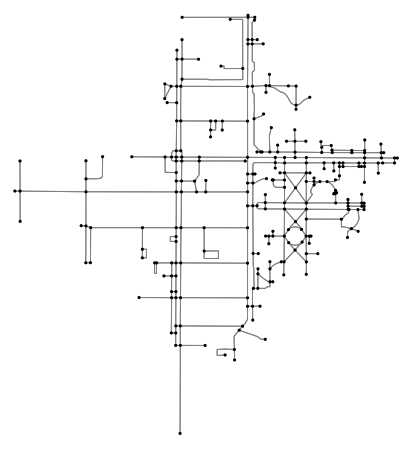

In [41]:
subgraph = nx.ego_graph(graph_proj, orig_node, radius=10, distance="time")
fig, ax = ox.plot_graph(subgraph, bgcolor='white', node_color='black', edge_color='grey', node_size=10)

## Produce isochrone map

We now have all the components to calculate the nodes that are within certain walking times from Condon Hall. We will use walking times of 5 to 45 minutes in 5-minute intervals.  

In [284]:
trip_times = [5, 10, 15, 20, 25, 30, 35, 40, 45]  # in minutes

Next, we will define a color for each trip time (or isochrone).

In [285]:
# get one color for each isochrone
iso_colors = ox.plot.get_colors(n=len(trip_times), cmap="plasma", start=0, return_hex=True)

This next bit gets a little hairy but basically we will assign each node a color based on the travel time from Condon Hall. We found this code from [here](https://github.com/gboeing/osmnx-examples/blob/main/notebooks/13-isolines-isochrones.ipynb). We're not sure we could have written this ourselves but it's perfectly OK to appropriate someone else's code if it works.

In [298]:
# color the nodes according to isochrone then plot the street network
node_colors = {}
for trip_time, color in zip(sorted(trip_times, reverse=True), iso_colors):
    subgraph = nx.ego_graph(graph_proj, orig_node, radius=trip_time, distance="time")
    for node in subgraph.nodes():
        node_colors[node] = color

nc = [node_colors[node] if node in node_colors else "none" for node in graph_proj.nodes()]
ns = [10 if node in node_colors else 0 for node in graph_proj.nodes()]

Now we can plot our colored nodes onto the original graph.

/home/johnny/anaconda3/envs/gds/lib/python3.8/site-packages/geopandas/plotting.py:74: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if mpl >= LooseVersion("3.4") or (mpl > LooseVersion("3.3.2") and "+" in mpl):
/home/johnny/anaconda3/envs/gds/lib/python3.8/site-packages/setuptools/_distutils/version.py:351: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)


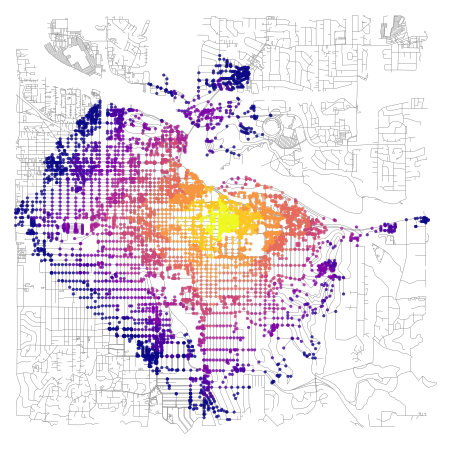

In [299]:
fig, ax = ox.plot_graph(graph_proj, node_color=nc, node_size=ns, node_alpha=0.8,
    edge_linewidth=0.2, edge_color="grey", bgcolor='white')

This looks great but is of limited use since the buildings that we want to travel to are not necessarily associated with nodes. It would be more convenient to convert this data into polygons which we could use to intersect buildings (or points) of interest.

## Isochrone polygons

Again, we found this code from [here](https://github.com/gboeing/osmnx-examples/blob/main/notebooks/13-isolines-isochrones.ipynb), don't worry if you don't understand it. We first define a function to make the isochrone polygons from positions of the nodes.

In [309]:
def make_iso_polys(G, edge_buff=25, node_buff=50, infill=False):
    isochrone_polys = []
    for trip_time in sorted(trip_times, reverse=True):
        subgraph = nx.ego_graph(G, orig_node, radius=trip_time, distance='time')

        node_points = [Point((data['x'], data['y'])) for node, data in subgraph.nodes(data=True)]
        nodes_gdf = gpd.GeoDataFrame({'id': subgraph.nodes()}, geometry=node_points)
        nodes_gdf = nodes_gdf.set_index('id')

        edge_lines = []
        for n_fr, n_to in subgraph.edges():
            f = nodes_gdf.loc[n_fr].geometry
            t = nodes_gdf.loc[n_to].geometry
            edge_lookup = G.get_edge_data(n_fr, n_to)[0].get('geometry',  LineString([f,t]))
            edge_lines.append(edge_lookup)

        n = nodes_gdf.buffer(node_buff).geometry
        e = gpd.GeoSeries(edge_lines).buffer(edge_buff).geometry
        all_gs = list(n) + list(e)
        new_iso = gpd.GeoSeries(all_gs).unary_union
        
        # try to fill in surrounded areas so shapes will appear solid and blocks without white space inside them
        if infill:
            new_iso = Polygon(new_iso.exterior)
        isochrone_polys.append(new_iso)
    return isochrone_polys

Next we will call the function...

In [347]:
isochrone_polys = make_iso_polys(graph_proj, edge_buff=25, node_buff=0, infill=True)

And plot!

/home/johnny/anaconda3/envs/gds/lib/python3.8/site-packages/geopandas/plotting.py:74: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if mpl >= LooseVersion("3.4") or (mpl > LooseVersion("3.3.2") and "+" in mpl):
/home/johnny/anaconda3/envs/gds/lib/python3.8/site-packages/setuptools/_distutils/version.py:351: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)
/home/johnny/anaconda3/envs/gds/lib/python3.8/site-packages/descartes/patch.py:62: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  vertices = concatenate([


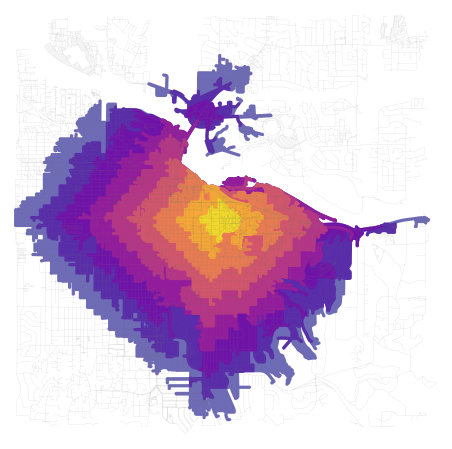

In [348]:
fig, ax = ox.plot_graph(graph_proj, show=False, close=False, edge_linewidth=0.2, 
                        edge_color="grey", bgcolor='white', edge_alpha=0.2, node_size=0)
for polygon, fc in zip(isochrone_polys, iso_colors):
    patch = PolygonPatch(polygon, fc=fc, ec='none', alpha=0.6, zorder=-1)
    ax.add_patch(patch)
plt.show()

Finally, let's intersect these polygons with our cafes to see which are within a given travel time. The `isochrone_polys` are actually in reverse order so the first polygon represents the longest travel time (i.e. 45 minutes) and the last polygon represents the shortest travel time (i.e. 5 minutes). 

So to find which cafes are within 20 minutes of walking we would use the **fourth last** item in the index (i.e. 5, 10, 15, **20**). Remember that if `-1` is the last item in the index, `-4` is the fourth last item.

In [337]:
cafes['20-minutes'] = cafes.intersects(isochrone_polys[-4])

In [342]:
cafes[['name', 'time_minutes', 'distance_km']][cafes['20-minutes'] == True]

,name,time_minutes,distance_km
4,Starbucks,16.258493,1.219387
5,Espresso Roma,2.155147,0.161636
6,Dutch Bros. Coffee,20.129840,1.509738
7,Greenleaf Juicing Company,3.298520,0.247389
10,Dutch Bros. Coffee,14.181133,1.063585
16,The Rabbit Hole,19.433293,1.457497


## Acknowledgments

This demo was inspired by material provided from the [NetworkX](https://networkx.org/documentation/stable/index.html) and [OSMnx](https://osmnx.readthedocs.io/en/stable/) docs as well as the [osmnx-examples](https://github.com/gboeing/osmnx-examples) produced by [Geoff Boeing](https://geoffboeing.com/).